In [3]:
import os
import torch
from torch import nn

class VGG11_VAE(nn.Module):
    def __init__(self, latent_dim=256):
        super(VGG11_VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_mu = nn.Linear(512 * 64 * 3, latent_dim)
        self.fc_logvar = nn.Linear(512 * 64 * 3, latent_dim)

        self.decoder_input = nn.Linear(latent_dim, 512 * 64 * 3)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(size=(128, 6)),
            
            nn.ConvTranspose2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(size=(256, 13)),
            
            nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(size=(512, 27)),
            
            nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(size=(1024, 54)),
            
            nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 1, kernel_size=3, padding=1),
            nn.Upsample(size=(2049, 108)),
        )
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        x = self.decoder_input(z)
        x = x.view(-1, 512, 64, 3)
        x = self.decoder(x)
        return x, mu, logvar
    
model = VGG11_VAE(256)
state_dict = torch.load('')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [4]:
import torch
import torchaudio
from torchaudio.transforms import MelSpectrogram, InverseMelScale, GriffinLim
import matplotlib.pyplot as plt

waveform, sample_rate = torchaudio.load("../../data/violin/2241_1.wav")
transform = torchaudio.transforms.Spectrogram(n_fft=4096)
specs = transform(waveform)
specs = specs / torch.max(specs)
print(specs.shape)

revert = torchaudio.transforms.GriffinLim(n_fft=4096)
re_waveform = revert(specs)
print(re_waveform.shape)

from IPython.display import Audio
Audio(re_waveform.detach().numpy(), rate=sample_rate)

torch.Size([1, 2049, 108])
torch.Size([1, 219136])


In [7]:
import torch
import torchaudio
from torchaudio.transforms import MelSpectrogram, InverseMelScale, GriffinLim
import matplotlib.pyplot as plt

waveform, sample_rate = torchaudio.load("../../data/violin/2241_1.wav")
transform = torchaudio.transforms.Spectrogram(n_fft=4096)
specs = transform(waveform)
specs = specs / torch.max(specs)
print(specs.shape)

#############################
specs = specs.unsqueeze(0)
specs, mu, logvar = model(specs)
specs = specs.squeeze(0)
print(specs.shape)
#############################

revert = torchaudio.transforms.GriffinLim(n_fft=4096)
re_waveform = revert(specs)
print(re_waveform.shape)

from IPython.display import Audio
Audio(re_waveform.detach().numpy(), rate=sample_rate)

torch.Size([1, 2049, 108])
torch.Size([1, 2049, 108])
torch.Size([1, 219136])


/opt/conda/envs/poza/lib/python3.10/site-packages/IPython/lib/display.py:188: RuntimeWarning: invalid value encountered in cast
  return scaled.astype("<h").tobytes(), nchan


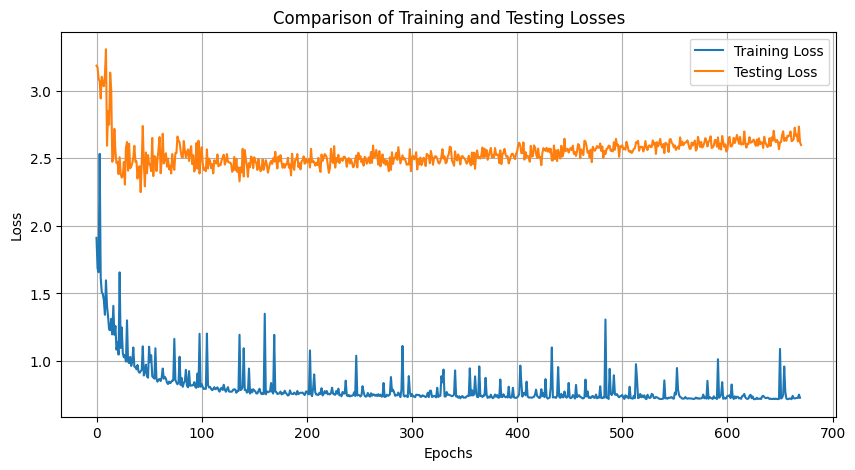

In [1]:
import pickle
import matplotlib.pyplot as plt

# Load data from pickle files
def load_pickle(file_name):
    with open(file_name, 'rb') as file:
        data = pickle.load(file)
    return data

test_loss = load_pickle('./out/violin/test_loss.pkl')
train_loss = load_pickle('./out/violin/train_loss.pkl')
t_loss = []
r_loss = []
for train in train_loss:
    if train <= 5:
        t_loss.append(train)
for train in test_loss:
    if train <= 5:
        r_loss.append(train)
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(t_loss, label='Training Loss')
plt.plot(r_loss, label='Testing Loss')
plt.title('Comparison of Training and Testing Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()